## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read
df = pd.read_csv('data/5guys_flight_data_preprocessed.csv')
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,TAIL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_DEL15,CRS_ARR_TIME,CRS_ELAPSED_TIME,...,TMAX,TMIN,WDF2,WDF5,WSF2,WT03,WT08,DEL_BLOCK_COUNT,DEL_ORIGIN_COUNT,WT_FOG
0,1,28,1,182,14,12,1028,1.0,1306,278.0,...,34.0,8.0,300.0,290.0,25.9,0.0,1.0,61308.0,74377.0,1
1,1,28,1,2365,14,3,1011,1.0,1200,169.0,...,34.0,8.0,300.0,290.0,25.9,0.0,1.0,61308.0,74377.0,1
2,1,28,1,1481,14,6,600,1.0,853,173.0,...,34.0,8.0,300.0,290.0,25.9,0.0,1.0,30794.0,74377.0,1
3,1,28,1,2401,14,3,851,0.0,1040,169.0,...,34.0,8.0,300.0,290.0,25.9,0.0,1.0,50662.0,74377.0,1
4,1,28,1,2941,14,12,754,1.0,1435,281.0,...,34.0,8.0,300.0,290.0,25.9,0.0,1.0,41350.0,74377.0,1


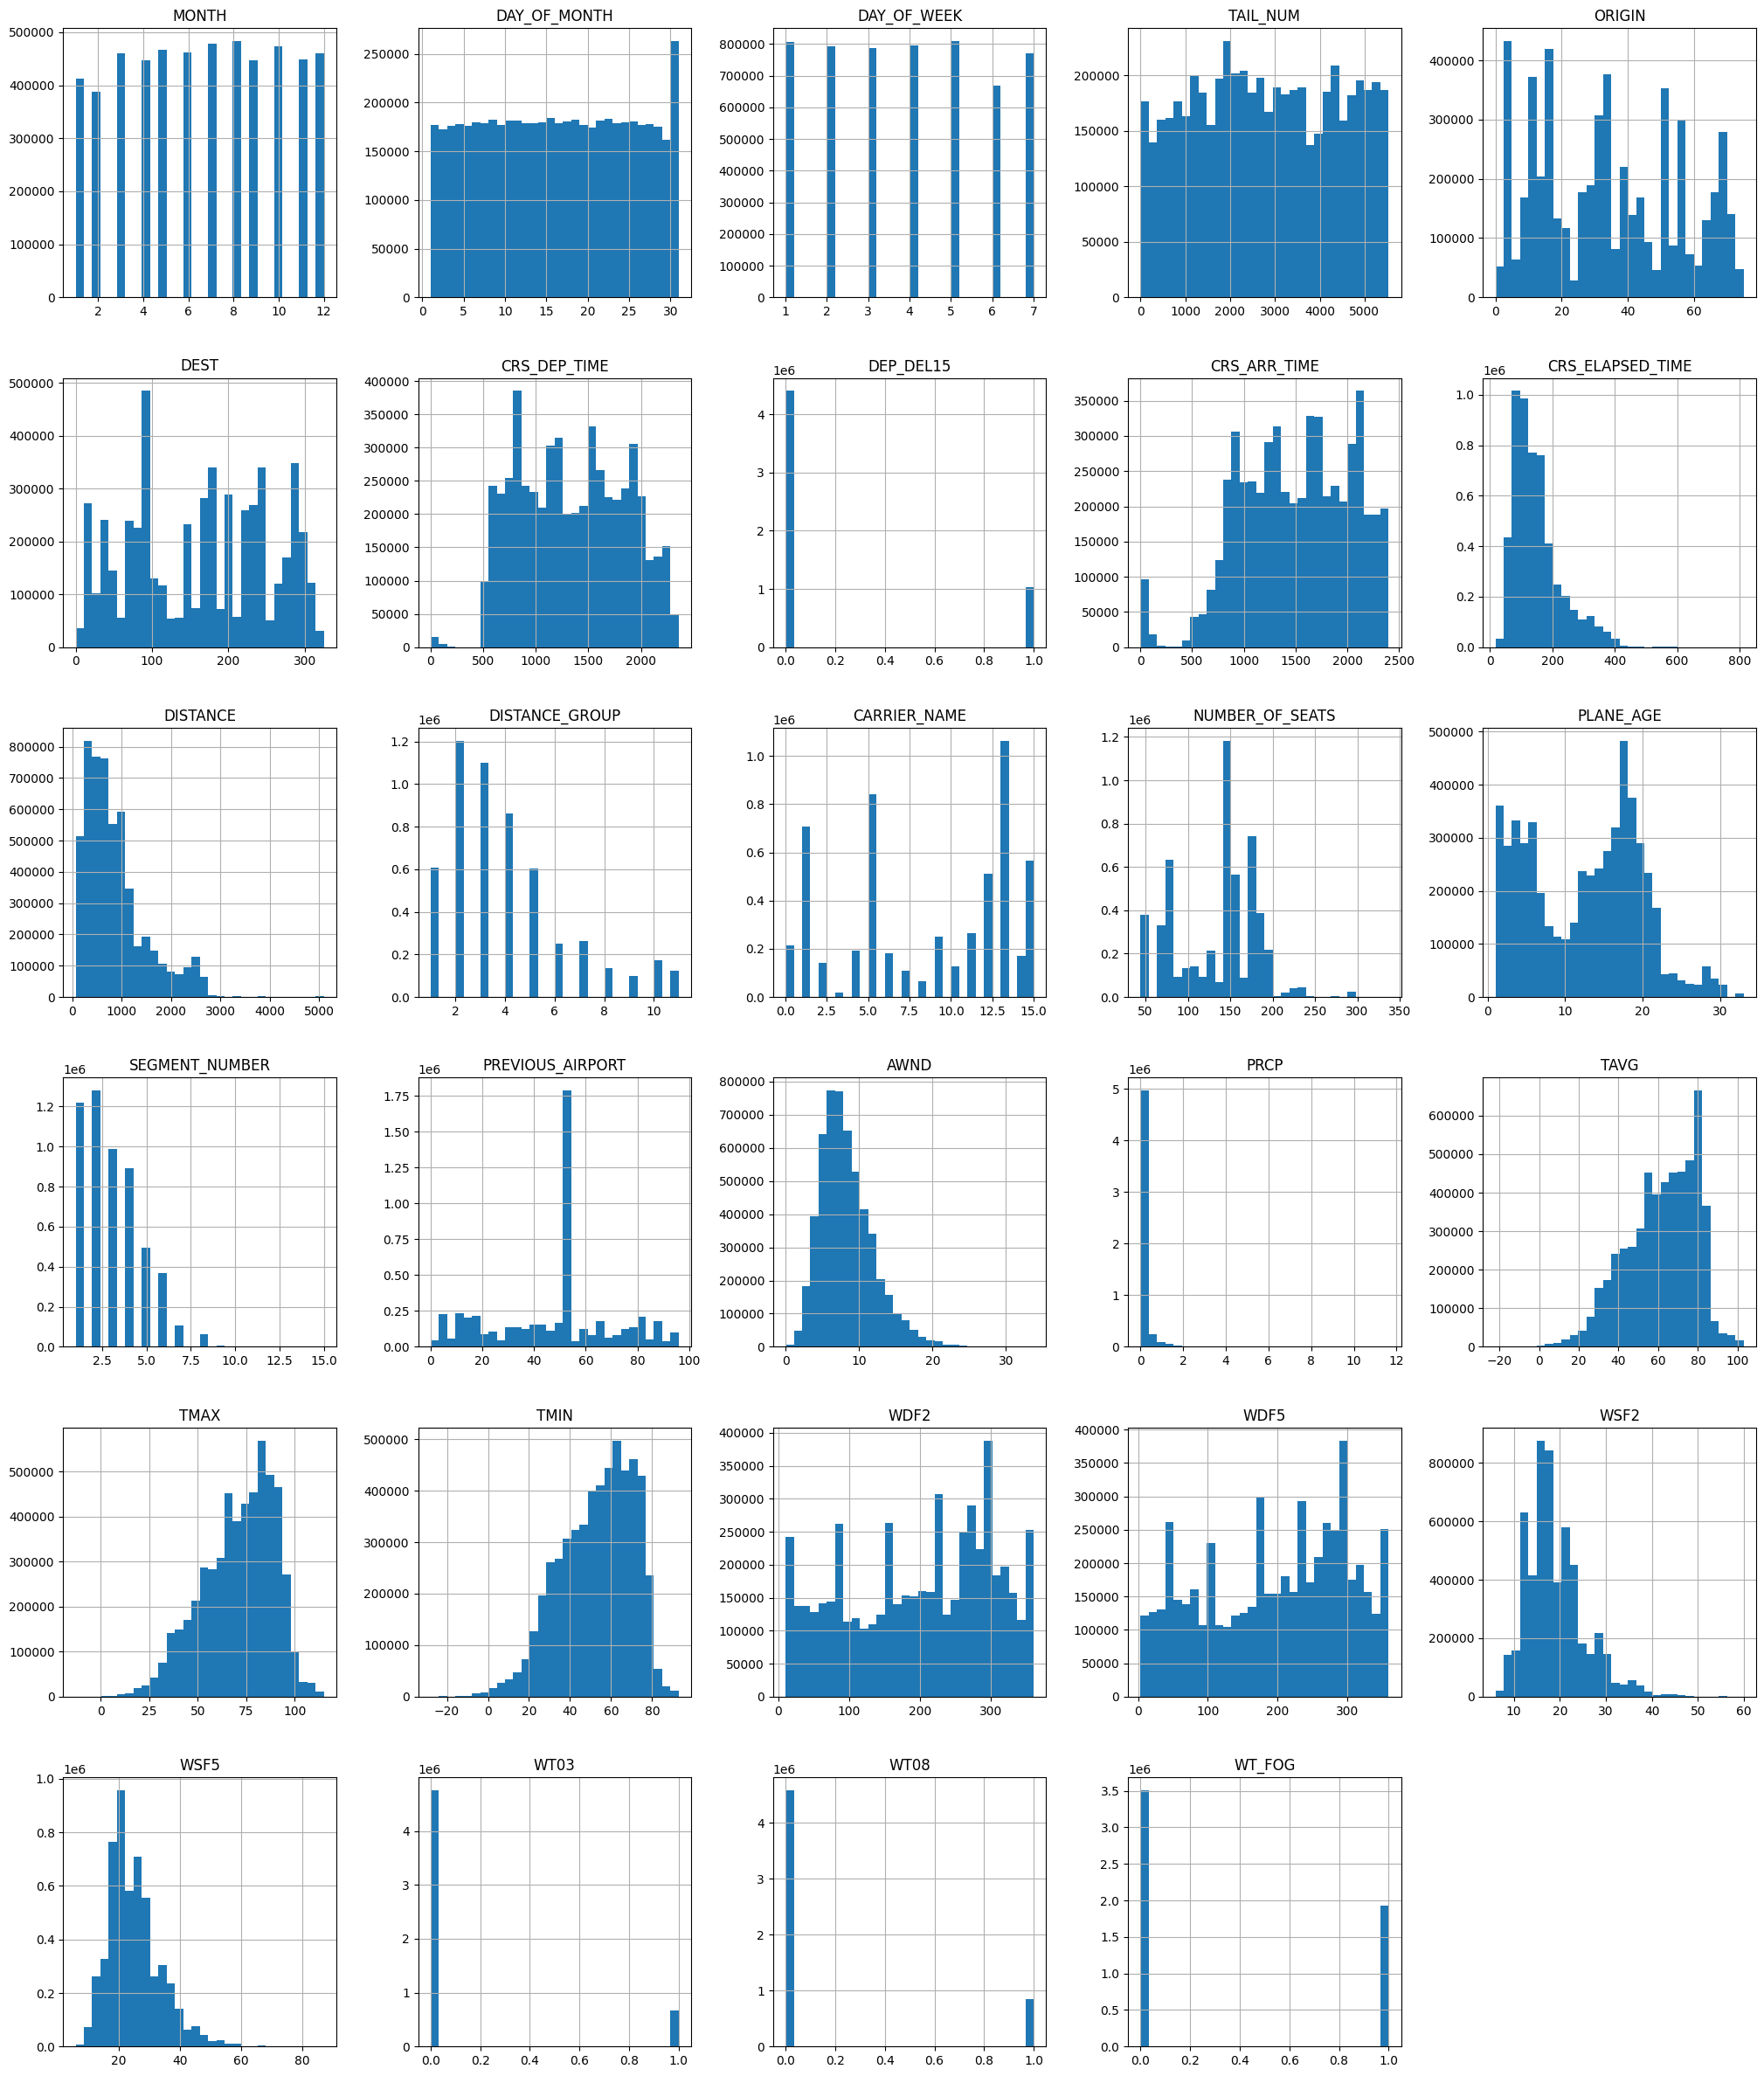

In [5]:
df.hist(bins=30, figsize=(25, 30));

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
sns.set(style="whitegrid")

# Select features for the pair plot
selected_features = [
    'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'MONTH', 'DAY_OF_MONTH', 
    'DISTANCE', 'AWND', 'TAVG', 'TMAX', 'TMIN', 'WT03', 'WT08', 'DEP_DEL15'
]

# Create a pair plot
pair_plot = sns.pairplot(df[selected_features], hue='DEP_DEL15', palette='viridis', height=3)

# Set title
pair_plot.fig.suptitle('Pair Plot: Multiple Features and DEP_DEL15', y=1.02)

# Show the plot
plt.show()


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x17fd0b490> (for post_execute):


KeyboardInterrupt: 

## Baseline Performance

Simple Model

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler

# Select all columns as features except the target column
features = df.columns.tolist()
features.remove('DEP_DEL15')

target = 'DEP_DEL15'  # You can choose another relevant column for binary classification
df = df.dropna(subset=[target])

# Split the dataset into training and testing sets
X = df[features]
y = df[target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Perform undersampling on the training data only
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression as a simple model
simple_model_lr = LogisticRegression(random_state=42)
simple_model_lr.fit(X_train_scaled, y_train_resampled)
y_pred_lr = simple_model_lr.predict(X_test_scaled)

# Decision Tree as a simple model
simple_model_dt = DecisionTreeClassifier(random_state=42)
simple_model_dt.fit(X_train_scaled, y_train_resampled)
y_pred_dt = simple_model_dt.predict(X_test_scaled)

# Evaluate Logistic Regression
accuracy_lr = accuracy_score(y_test, y_pred_lr)
confusion_lr = confusion_matrix(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr)

# Evaluate Decision Tree
accuracy_dt = accuracy_score(y_test, y_pred_dt)
confusion_dt = confusion_matrix(y_test, y_pred_dt)
report_dt = classification_report(y_test, y_pred_dt)

print('Logistic Regression Metrics:')
print(f'Accuracy: {accuracy_lr}')
print('Confusion Matrix:')
print(confusion_lr)
print('Classification Report:')
print(report_lr)

print('\nDecision Tree Metrics:')
print(f'Accuracy: {accuracy_dt}')
print('Confusion Matrix:')
print(confusion_dt)
print('Classification Report:')
print(report_dt)


Logistic Regression Metrics:
Accuracy: 0.590354212896038
Confusion Matrix:
[[255204 185207]
 [ 37245  65379]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.58      0.70    440411
         1.0       0.26      0.64      0.37    102624

    accuracy                           0.59    543035
   macro avg       0.57      0.61      0.53    543035
weighted avg       0.76      0.59      0.63    543035


Decision Tree Metrics:
Accuracy: 0.5953759886563481
Confusion Matrix:
[[261990 178421]
 [ 41304  61320]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.59      0.70    440411
         1.0       0.26      0.60      0.36    102624

    accuracy                           0.60    543035
   macro avg       0.56      0.60      0.53    543035
weighted avg       0.75      0.60      0.64    543035



Random Model(Evaluating Random Baseline)

In [4]:
import random

# Generate random predictions
y_pred_random = [random.choice([0, 1]) for _ in range(len(y_test))]

# Evaluate random baseline
accuracy_random = accuracy_score(y_test, y_pred_random)
confusion_random = confusion_matrix(y_test, y_pred_random)
report_random = classification_report(y_test, y_pred_random)

print('Random Baseline Metrics:')
print(f'Accuracy: {accuracy_random}')
print('Confusion Matrix:')
print(confusion_random)
print('Classification Report:')
print(report_random)


Random Baseline Metrics:
Accuracy: 0.4993121990295285
Confusion Matrix:
[[220088 220323]
 [ 51568  51056]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.50      0.62    440411
         1.0       0.19      0.50      0.27    102624

    accuracy                           0.50    543035
   macro avg       0.50      0.50      0.45    543035
weighted avg       0.69      0.50      0.55    543035



Majority Class Baseline

In [5]:
# Majority class baseline
majority_class = y_train_resampled.value_counts().idxmax()
y_pred_majority = [majority_class] * len(y_test)

# Evaluate majority class baseline
accuracy_majority = accuracy_score(y_test, y_pred_majority)
confusion_majority = confusion_matrix(y_test, y_pred_majority)
report_majority = classification_report(y_test, y_pred_majority)

print('Majority Class Baseline Metrics:')
print(f'Accuracy: {accuracy_majority}')
print('Confusion Matrix:')
print(confusion_majority)
print('Classification Report:')
print(report_majority)


/Users/terlan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Majority Class Baseline Metrics:
Accuracy: 0.8110177060410471
Confusion Matrix:
[[440411      0]
 [102624      0]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      1.00      0.90    440411
         1.0       0.00      0.00      0.00    102624

    accuracy                           0.81    543035
   macro avg       0.41      0.50      0.45    543035
weighted avg       0.66      0.81      0.73    543035



/Users/terlan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/terlan/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Feature Importance

Logistic Regression Feature Importance Scores: [-0.03185355  0.00101148 -0.01020575 -0.00696486  0.03715334  0.00412001
  0.25795691  0.0213686   0.17847285 -0.12126423  0.05336291  0.02982448
  0.01539627  0.02147215 -0.01390921  0.01677745  0.07548606  0.05709201
 -0.16571216  0.0912382   0.00657254 -0.00626785  0.07935855  0.11881918
  0.00733601  0.1449902   0.06791702  0.07045139]


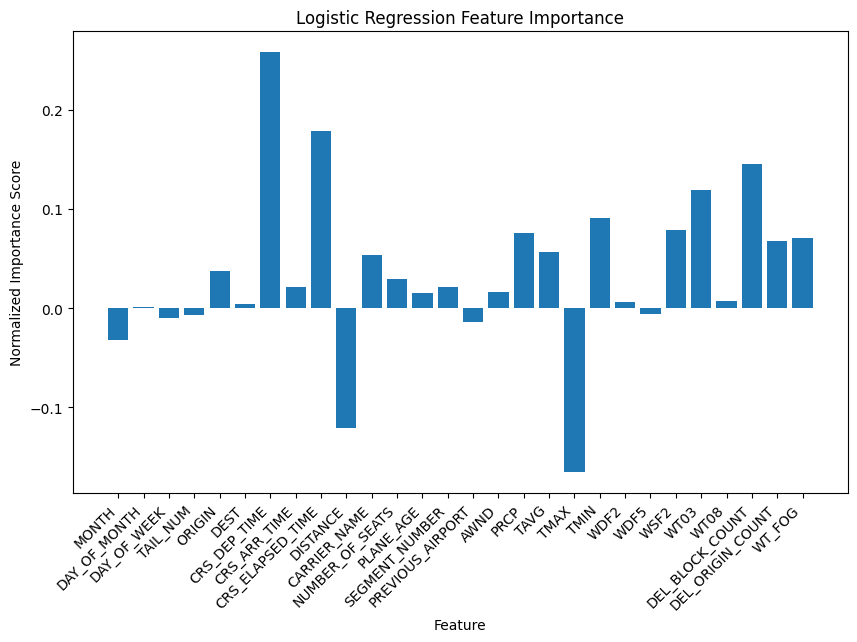

In [7]:
import matplotlib.pyplot as plt


# Get feature importances from Logistic Regression model
feature_importance_lr = simple_model_lr.coef_[0]

# Normalize the scores to have a sum of 1
feature_importance_normalized_lr = feature_importance_lr / np.sum(feature_importance_lr)

# Print or use the feature importance scores
print("Logistic Regression Feature Importance Scores:", feature_importance_normalized_lr)

# Plotting Logistic Regression Feature Importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance_normalized_lr)), feature_importance_normalized_lr, tick_label=X.columns)
plt.xlabel('Feature')
plt.ylabel('Normalized Importance Score')
plt.title('Logistic Regression Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.show()

Class distribution

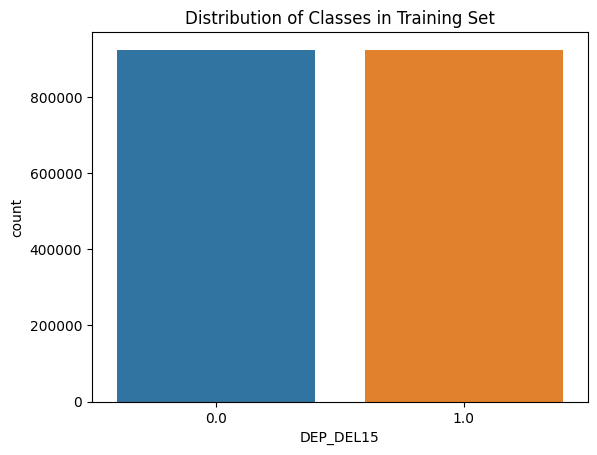

In [8]:
import seaborn as sns

# Visualization of class distribution
sns.countplot(x=y_train_resampled)
plt.title('Distribution of Classes in Training Set')
plt.show()


In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

print("Keras is installed successfully!")


TensorFlow version: 2.13.0
Keras is installed successfully!


Epoch 1/10
5773/5773 [==============================] - 50s 9ms/step - loss: 0.6604 - accuracy: 0.6035 - val_loss: 0.6615 - val_accuracy: 0.5985
Epoch 2/10
5773/5773 [==============================] - 50s 9ms/step - loss: 0.6593 - accuracy: 0.6044 - val_loss: 0.6586 - val_accuracy: 0.6035
Epoch 3/10
5773/5773 [==============================] - 51s 9ms/step - loss: 0.6652 - accuracy: 0.6004 - val_loss: 0.6592 - val_accuracy: 0.6064
Epoch 4/10
5773/5773 [==============================] - 50s 9ms/step - loss: 0.6729 - accuracy: 0.5946 - val_loss: 0.6848 - val_accuracy: 0.5989
Epoch 5/10
5773/5773 [==============================] - 50s 9ms/step - loss: 0.6818 - accuracy: 0.5905 - val_loss: 0.6955 - val_accuracy: 0.5976
Epoch 6/10
5773/5773 [==============================] - 50s 9ms/step - loss: 0.6922 - accuracy: 0.5863 - val_loss: 0.6578 - val_accuracy: 0.6039
Epoch 7/10
5773/5773 [==============================] - 50s 9ms/step - loss: 0.7096 - accuracy: 0.5825 - val_loss: 0.7080 - val_ac

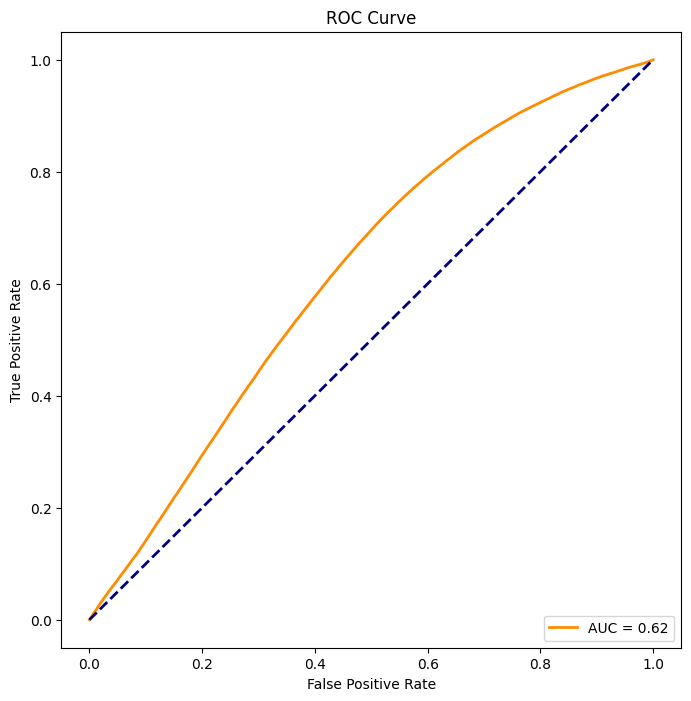

Accuracy: 0.5681272846133306
Confusion Matrix:
[[243177 197234]
 [ 37288  65336]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.55      0.67    440411
         1.0       0.25      0.64      0.36    102624

    accuracy                           0.57    543035
   macro avg       0.56      0.59      0.52    543035
weighted avg       0.75      0.57      0.61    543035



In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers


# Assuming df is your DataFrame with features and labels, and the label column is named 'target'
# X contains your features (all columns except 'target'), y contains your labels ('target')

# Select all columns as features except the target column
features = df.columns.tolist()
features.remove('DEP_DEL15')

# Remove 'TMAX' and 'distance' from the list of features
#features_to_exclude = ['TMAX', 'DISTANCE']
#features = [feature for feature in features if feature not in features_to_exclude]


target = 'DEP_DEL15'  # You can choose another relevant column for binary classification
df = df.dropna(subset=[target])

# Split the dataset into training and testing sets
X = df[features]
y = df[target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Perform undersampling on the training data only
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Build a simple neural network
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))  # Adding one more hidden layer
model.add(Dense(1, activation='sigmoid'))


# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train_resampled, test_size=0.2, stratify=y_train_resampled,random_state=42)
history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_val, y_val), verbose=1)

# Make predictions on the test set
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model on the original test set
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)

# Confusion matrix
#plt.figure(figsize=(6, 6))
#plot_confusion_matrix(model, X_test_scaled, y_test, display_labels=['Not Delayed', 'Delayed'])
#plt.title('Confusion Matrix (After Undersampling)')
#plt.show()


Epoch 1/25
5773/5773 [==============================] - 50s 9ms/step - loss: 0.6668 - accuracy: 0.5991 - val_loss: 0.6662 - val_accuracy: 0.5954
Epoch 2/25
5773/5773 [==============================] - 54s 9ms/step - loss: 0.7044 - accuracy: 0.5814 - val_loss: 0.9056 - val_accuracy: 0.5532
Epoch 3/25
5773/5773 [==============================] - 54s 9ms/step - loss: 0.7844 - accuracy: 0.5677 - val_loss: 0.9681 - val_accuracy: 0.5491
Epoch 4/25
5773/5773 [==============================] - 54s 9ms/step - loss: 0.9658 - accuracy: 0.5556 - val_loss: 0.9040 - val_accuracy: 0.5781
Epoch 5/25
5773/5773 [==============================] - 50s 9ms/step - loss: 1.2938 - accuracy: 0.5479 - val_loss: 0.7541 - val_accuracy: 0.5878
Epoch 6/25
5773/5773 [==============================] - 48s 8ms/step - loss: 1.6430 - accuracy: 0.5434 - val_loss: 1.8618 - val_accuracy: 0.5791
Epoch 7/25
5773/5773 [==============================] - 45s 8ms/step - loss: 2.1770 - accuracy: 0.5409 - val_loss: 3.3554 - val_ac

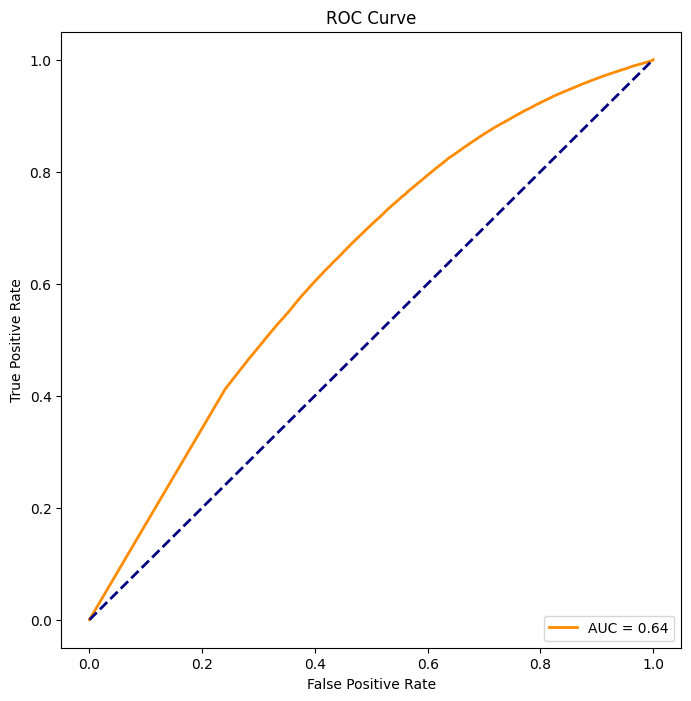

Accuracy: 0.5819072435478376
Confusion Matrix:
[[250651 189760]
 [ 37279  65345]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.57      0.69    440411
         1.0       0.26      0.64      0.37    102624

    accuracy                           0.58    543035
   macro avg       0.56      0.60      0.53    543035
weighted avg       0.75      0.58      0.63    543035



In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout, BatchNormalization


# Assuming df is your DataFrame with features and labels, and the label column is named 'target'
# X contains your features (all columns except 'target'), y contains your labels ('target')

# Select all columns as features except the target column
features = df.columns.tolist()
features.remove('DEP_DEL15')

target = 'DEP_DEL15'  # You can choose another relevant column for binary classification
df = df.dropna(subset=[target])

# Split the dataset into training and testing sets
X = df[features]
y = df[target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Perform undersampling on the training data only
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Build a simple neural network
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))  # Adding one more hidden layer
model.add(Dense(1, activation='sigmoid'))


# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizers.Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train_resampled, test_size=0.2, stratify=y_train_resampled,random_state=42)
history = model.fit(X_train, y_train, epochs=25, batch_size=256, validation_data=(X_val, y_val), verbose=1)

# Make predictions on the test set
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model on the original test set
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)

# Confusion matrix
#plt.figure(figsize=(6, 6))
#plot_confusion_matrix(model, X_test_scaled, y_test, display_labels=['Not Delayed', 'Delayed'])
#plt.title('Confusion Matrix (After Undersampling)')
#plt.show()


Epoch 1/10
12828/12828 [==============================] - 225s 17ms/step - loss: 0.6625 - accuracy: 0.6021 - val_loss: 0.6515 - val_accuracy: 0.5948
Epoch 2/10
12828/12828 [==============================] - 223s 17ms/step - loss: 0.6620 - accuracy: 0.6022 - val_loss: 0.6316 - val_accuracy: 0.6266
Epoch 3/10
12828/12828 [==============================] - 207s 16ms/step - loss: 0.6619 - accuracy: 0.6024 - val_loss: 0.6735 - val_accuracy: 0.5653
Epoch 4/10
12828/12828 [==============================] - 204s 16ms/step - loss: 0.6621 - accuracy: 0.6022 - val_loss: 0.6653 - val_accuracy: 0.5745
Epoch 5/10
12828/12828 [==============================] - 204s 16ms/step - loss: 0.6622 - accuracy: 0.6022 - val_loss: 0.6629 - val_accuracy: 0.5792
Epoch 6/10
12828/12828 [==============================] - 204s 16ms/step - loss: 0.6620 - accuracy: 0.6024 - val_loss: 0.6628 - val_accuracy: 0.5790
Epoch 7/10
12828/12828 [==============================] - 204s 16ms/step - loss: 0.6619 - accuracy: 0.6023

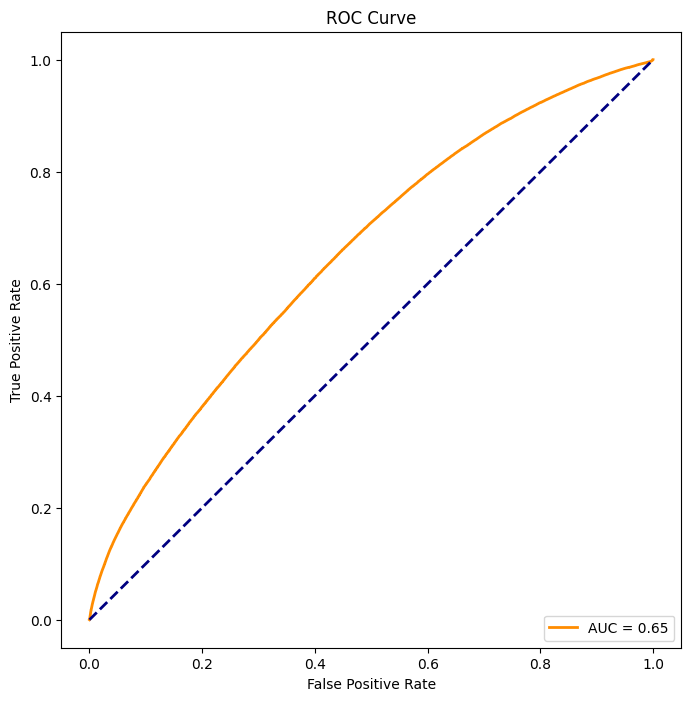

Accuracy: 0.5923319859677553
Confusion Matrix:
[[257360 183051]
 [ 38327  64297]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.58      0.70    440411
         1.0       0.26      0.63      0.37    102624

    accuracy                           0.59    543035
   macro avg       0.57      0.61      0.53    543035
weighted avg       0.76      0.59      0.64    543035



In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout, BatchNormalization


# Assuming df is your DataFrame with features and labels, and the label column is named 'target'
# X contains your features (all columns except 'target'), y contains your labels ('target')

# Select all columns as features except the target column
features = df.columns.tolist()
features.remove('DEP_DEL15')

# Remove 'TMAX' and 'distance' from the list of features
features_to_exclude = ['TMAX', 'distance']
features = [feature for feature in features if feature not in features_to_exclude]

target = 'DEP_DEL15'  # You can choose another relevant column for binary classification
df = df.dropna(subset=[target])

# Split the dataset into training and testing sets
X = df[features]
y = df[target]

# Split the dataset into training and testing sets
# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Perform undersampling on the training data only
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Build a simple neural network
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.Adam(learning_rate=0.02), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train_resampled, epochs=10, batch_size=128, validation_data=(X_val_scaled, y_val), verbose=1)

# Make predictions on the test set
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model on the original test set
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)

# Confusion matrix
#plt.figure(figsize=(6, 6))
#plot_confusion_matrix(model, X_test_scaled, y_test, display_labels=['Not Delayed', 'Delayed'])
#plt.title('Confusion Matrix (After Undersampling)')
#plt.show()


Epoch 1/20
12828/12828 [==============================] - 530s 41ms/step - loss: 0.6470 - accuracy: 0.6237 - val_loss: 0.6246 - val_accuracy: 0.6534
Epoch 2/20
12828/12828 [==============================] - 519s 40ms/step - loss: 0.6309 - accuracy: 0.6392 - val_loss: 0.6335 - val_accuracy: 0.6422
Epoch 3/20
12828/12828 [==============================] - 494s 38ms/step - loss: 0.6263 - accuracy: 0.6444 - val_loss: 0.6357 - val_accuracy: 0.6455
Epoch 4/20
12828/12828 [==============================] - 521s 41ms/step - loss: 0.6237 - accuracy: 0.6465 - val_loss: 0.6230 - val_accuracy: 0.6581
Epoch 5/20
12828/12828 [==============================] - 524s 41ms/step - loss: 0.6223 - accuracy: 0.6480 - val_loss: 0.6151 - val_accuracy: 0.6706
Epoch 6/20
12828/12828 [==============================] - 519s 40ms/step - loss: 0.6208 - accuracy: 0.6495 - val_loss: 0.6240 - val_accuracy: 0.6495
Epoch 7/20
12828/12828 [==============================] - 519s 40ms/step - loss: 0.6199 - accuracy: 0.6502

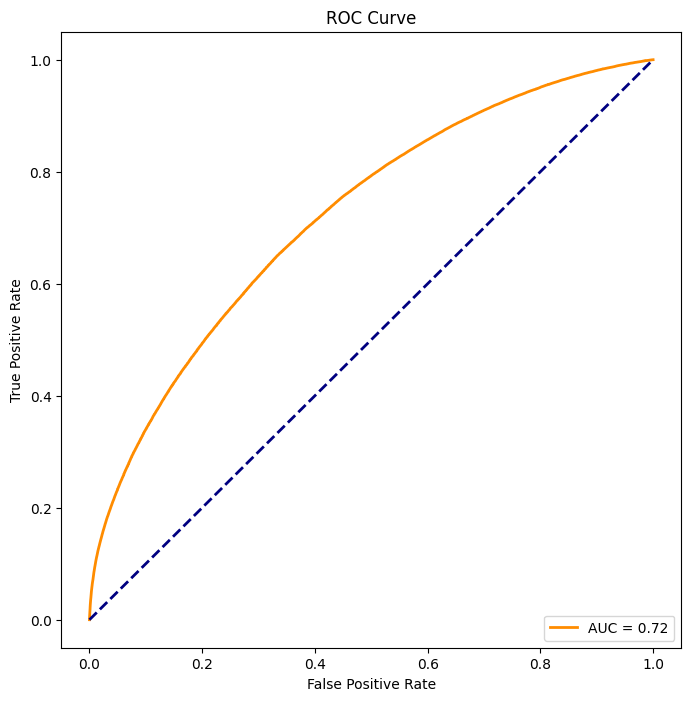

Accuracy: 0.6855506551143112
Confusion Matrix:
[[309713 130698]
 [ 40059  62565]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.70      0.78    440411
         1.0       0.32      0.61      0.42    102624

    accuracy                           0.69    543035
   macro avg       0.60      0.66      0.60    543035
weighted avg       0.78      0.69      0.72    543035



In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with features and labels, and the label column is named 'target'
# X contains your features (all columns except 'target'), y contains your labels ('target')

# Select all columns as features except the target column
features = df.columns.tolist()
features.remove('DEP_DEL15')

target = 'DEP_DEL15'  # You can choose another relevant column for binary classification
df = df.dropna(subset=[target])

# Split the dataset into training and testing sets
X = df[features]
y = df[target]

# Split the dataset into training and testing sets
# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Perform undersampling on the training data only
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build an improved LSTM model
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(1, X_train_scaled.shape[1]), return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_reshaped, y_train_resampled, epochs=20, batch_size=128, validation_data=(X_val_reshaped, y_val), verbose=1)

# Make predictions on the test set
y_pred_proba = model.predict(X_test_reshaped)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model on the original test set
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)


In [13]:
from sklearn.metrics import fbeta_score, f1_score

# Calculate additional metrics
#f2 score combines recall and precision with weighting 
#In this case, with β=2, more emphasis is placed on recall than precision.
f2 = fbeta_score(y_test, y_pred, beta=2)

f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')

# Print the metrics
print(f'Accuracy: {accuracy}')
print(f'F2 Score: {f2}')
print(f'F1 Micro: {f1_micro}')
print(f'F1 Macro: {f1_macro}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)

Accuracy: 0.6668870330641672
F2 Score: 0.5162381728565028
F1 Micro: 0.6668870330641672
F1 Macro: 0.590167631229872
Confusion Matrix:
[[298547 141864]
 [ 39028  63596]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.68      0.77    440411
         1.0       0.31      0.62      0.41    102624

    accuracy                           0.67    543035
   macro avg       0.60      0.65      0.59    543035
weighted avg       0.78      0.67      0.70    543035



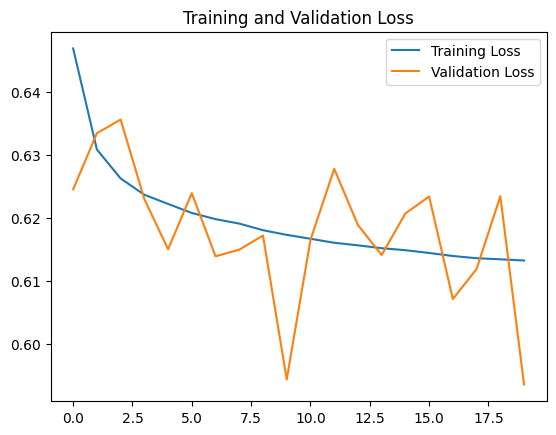

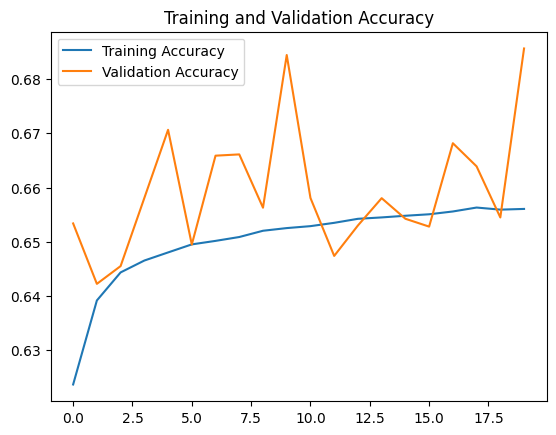

In [38]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


Epoch 1/20
12828/12828 [==============================] - 710s 55ms/step - loss: 0.6971 - accuracy: 0.5900 - val_loss: 0.6397 - val_accuracy: 0.6294
Epoch 2/20
12828/12828 [==============================] - 676s 53ms/step - loss: 0.6397 - accuracy: 0.6295 - val_loss: 0.6294 - val_accuracy: 0.6499
Epoch 3/20
12828/12828 [==============================] - 659s 51ms/step - loss: 0.6328 - accuracy: 0.6373 - val_loss: 0.6265 - val_accuracy: 0.6550
Epoch 4/20
12828/12828 [==============================] - 708s 55ms/step - loss: 0.6287 - accuracy: 0.6417 - val_loss: 0.6220 - val_accuracy: 0.6606
Epoch 5/20
12828/12828 [==============================] - 733s 57ms/step - loss: 0.6254 - accuracy: 0.6456 - val_loss: 0.6172 - val_accuracy: 0.6662
Epoch 6/20
12828/12828 [==============================] - 688s 54ms/step - loss: 0.6226 - accuracy: 0.6484 - val_loss: 0.6203 - val_accuracy: 0.6640
Epoch 7/20
12828/12828 [==============================] - 737s 57ms/step - loss: 0.6204 - accuracy: 0.6515

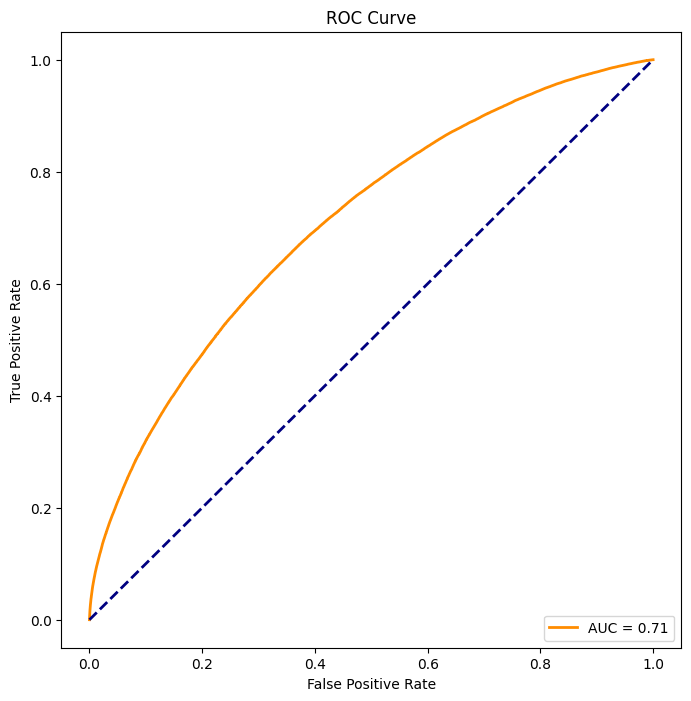

Accuracy: 0.6668870330641672
Confusion Matrix:
[[298547 141864]
 [ 39028  63596]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.68      0.77    440411
         1.0       0.31      0.62      0.41    102624

    accuracy                           0.67    543035
   macro avg       0.60      0.65      0.59    543035
weighted avg       0.78      0.67      0.70    543035



In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping


# Assuming df is your DataFrame with features and labels, and the label column is named 'target'
# X contains your features (all columns except 'target'), y contains your labels ('target')

# Select all columns as features except the target column
features = df.columns.tolist()
features.remove('DEP_DEL15')

# Remove 'TMAX' and 'distance' from the list of features
features_to_exclude = ['TMAX', 'distance']
features = [feature for feature in features if feature not in features_to_exclude]

target = 'DEP_DEL15'  # You can choose another relevant column for binary classification
df = df.dropna(subset=[target])

# Split the dataset into training and testing sets
X = df[features]
y = df[target]

# Split the dataset into training and testing sets
# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Perform undersampling on the training data only
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build a super complex LSTM model
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(1, X_train_scaled.shape[1]), return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_reshaped, y_train_resampled,
    epochs=20, batch_size=128,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[early_stopping],
    verbose=1
)
# Make predictions on the test set
y_pred_proba = model.predict(X_test_reshaped)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model on the original test set
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)


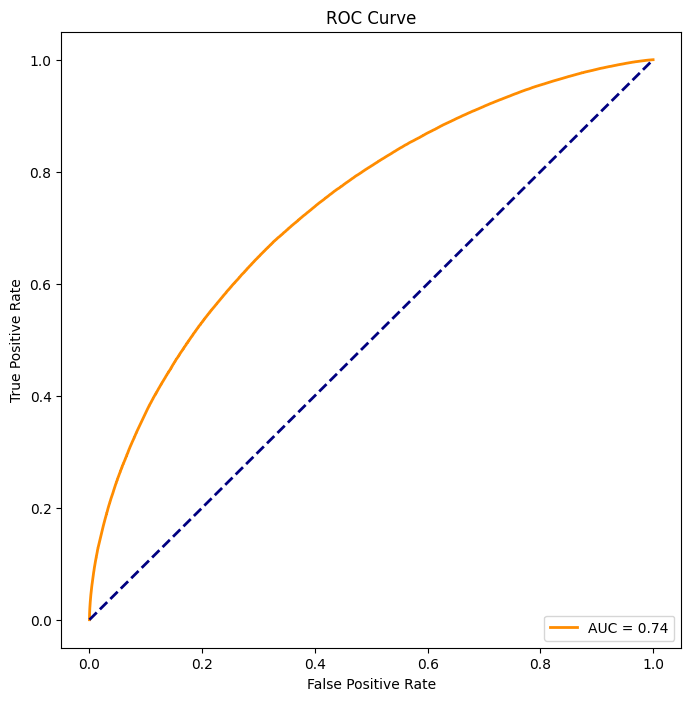

Accuracy: 0.6832908406371971
Confusion Matrix:
[[606773 274048]
 [ 69920 135328]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.69      0.78    880821
         1.0       0.33      0.66      0.44    205248

    accuracy                           0.68   1086069
   macro avg       0.61      0.67      0.61   1086069
weighted avg       0.79      0.68      0.72   1086069



/Users/terlan/anaconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 600x600 with 0 Axes>

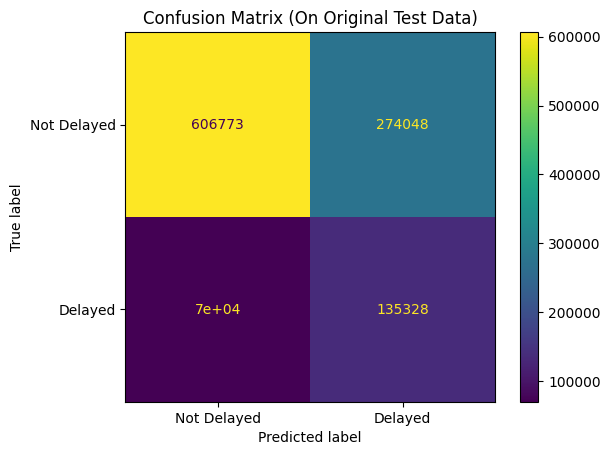

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

# Select all columns as features except the target column
features = df.columns.tolist()
features.remove('DEP_DEL15')

target = 'DEP_DEL15'  # You can choose another relevant column for binary classification
df = df.dropna(subset=[target])

# Split the dataset into training and testing sets
X = df[features]
y = df[target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Perform RandomUnderSampler undersampling on the training data only
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Create and train an XGBoost classification model on the resampled training data
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the original test set
y_pred = model.predict(X_test)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model on the original test set
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)

# Confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(model, X_test, y_test, display_labels=['Not Delayed', 'Delayed'])
plt.title('Confusion Matrix (On Original Test Data)')
plt.show()


### Balancing with SMOTE and training with XGBoost

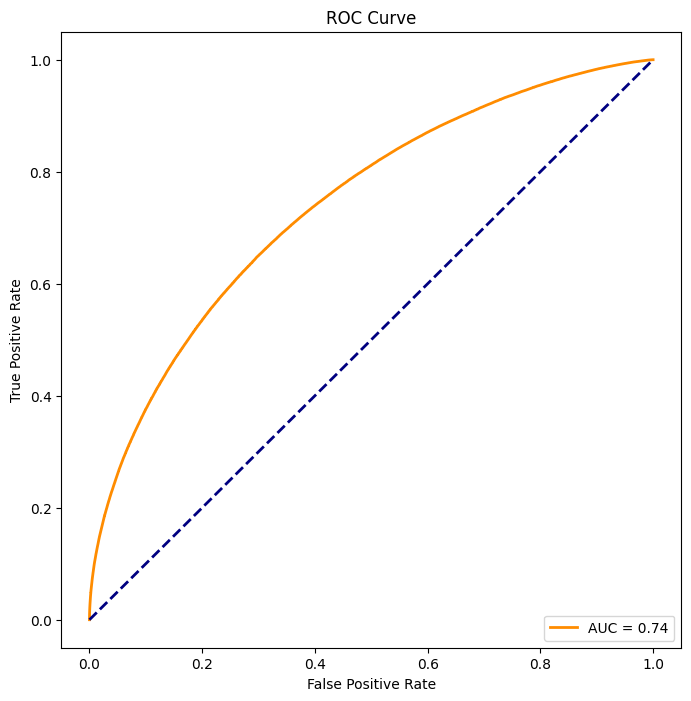

Accuracy: 0.8242791203873787
Confusion Matrix:
[[867733  13088]
 [177757  27491]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.99      0.90    880821
         1.0       0.68      0.13      0.22    205248

    accuracy                           0.82   1086069
   macro avg       0.75      0.56      0.56   1086069
weighted avg       0.80      0.82      0.77   1086069



/Users/terlan/anaconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 600x600 with 0 Axes>

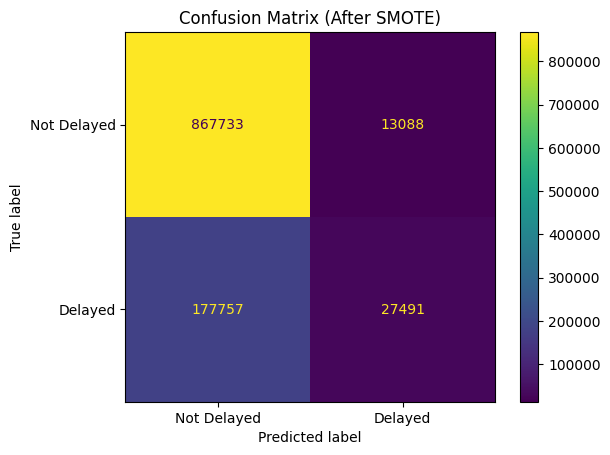

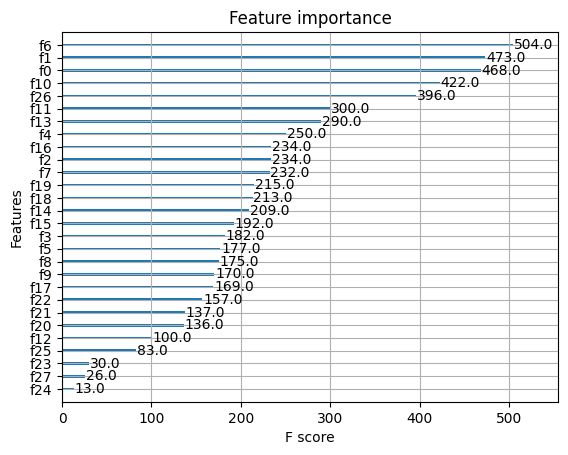

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler


# Select all columns as features except the target column
features = df.columns.tolist()
features.remove('DEP_DEL15')

target = 'DEP_DEL15'  # You can choose another relevant column for binary classification
df = df.dropna(subset=[target])

# Split the dataset into training and testing sets
X = df[features]
y = df[target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Perform RandomUnderSampler undersampling on the training data only
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Use StandardScaler to scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train an XGBoost classification model
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)

# Confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(model, X_test_scaled, y_test, display_labels=['Not Delayed', 'Delayed'])
plt.title('Confusion Matrix (After SMOTE)')
plt.show()

# Plot the feature importances
xgb.plot_importance(model)
plt.show()


Scores for each fold: [0.67816734 0.67691817 0.67632109 0.67795286 0.67614213]
Mean f1 score: 0.677


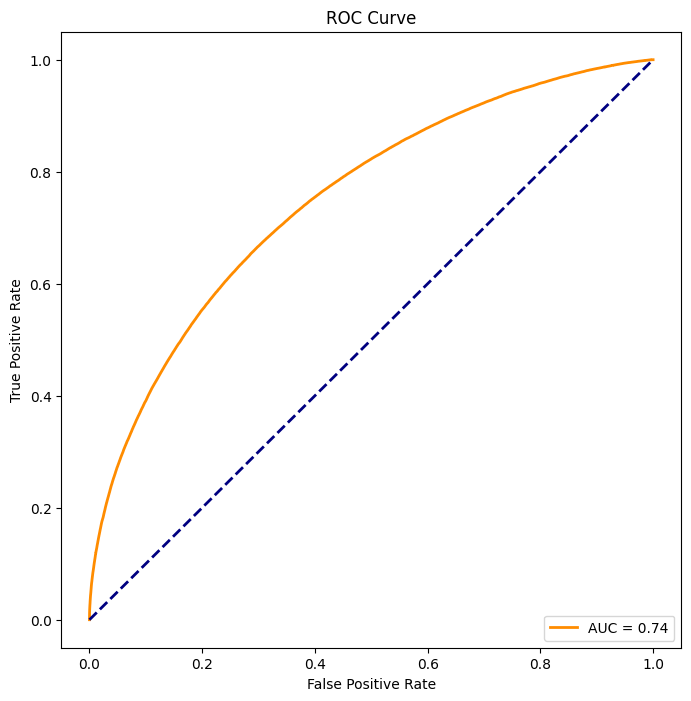

Accuracy: 0.6941965066708408
Confusion Matrix:
[[308557 131854]
 [ 34208  68416]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.70      0.79    440411
         1.0       0.34      0.67      0.45    102624

    accuracy                           0.69    543035
   macro avg       0.62      0.68      0.62    543035
weighted avg       0.79      0.69      0.72    543035



/Users/terlan/anaconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 600x600 with 0 Axes>

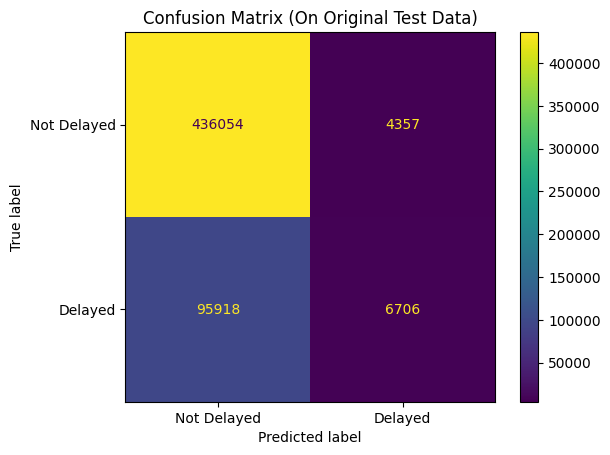

In [16]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier


# Select all columns as features except the target column
features = df.columns.tolist()
features.remove('DEP_DEL15')

target = 'DEP_DEL15'

# Split the dataset into training and testing sets
X = df[features]
y = df[target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Perform undersampling on the training data only
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

cb = CatBoostClassifier(random_state=42, verbose=False, depth= 10, iterations= 300, l2_leaf_reg= 1, learning_rate= 0.15)

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(cb, X_train_scaled, y_train_resampled, cv=cv, scoring='f1')

# Print the mean of the cross validation scores
print(f'Scores for each fold: {scores}')
print(f'Mean f1 score: {scores.mean():.3f}')

# Train CatBoost classifier
cb.fit(X_train_scaled, y_train_resampled)

# Predict on test data
y_pred = cb.predict(X_test_scaled)
y_pred_proba = cb.predict_proba(X_test_scaled)[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Display metrics
# Evaluate the model on the original test set
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)

# Confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(model, X_test_scaled, y_test, display_labels=['Not Delayed', 'Delayed'])
plt.title('Confusion Matrix (On Original Test Data)')
plt.show()

Scores for each fold: [0.67816734 0.67691817 0.67632109 0.67795286 0.67614213]
Mean f1 score: 0.677


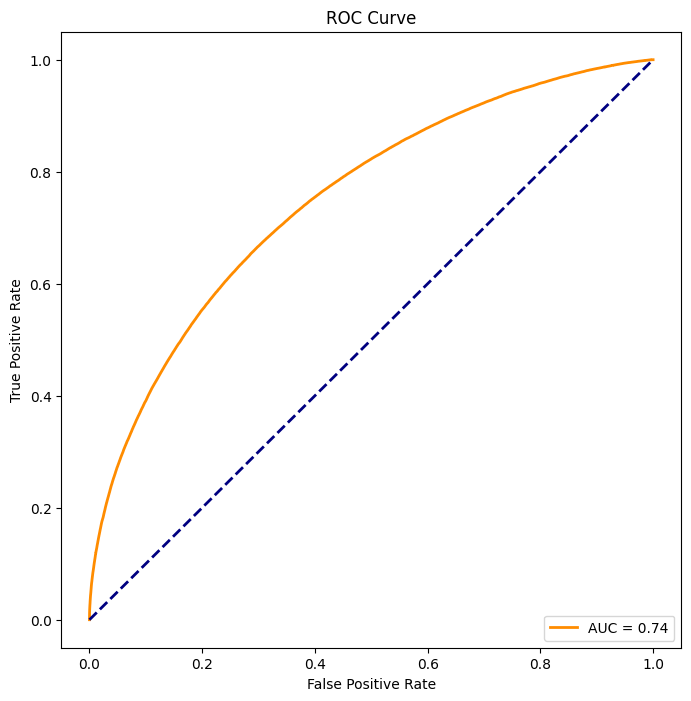

Accuracy: 0.6941965066708408
Confusion Matrix:
[[308557 131854]
 [ 34208  68416]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.70      0.79    440411
         1.0       0.34      0.67      0.45    102624

    accuracy                           0.69    543035
   macro avg       0.62      0.68      0.62    543035
weighted avg       0.79      0.69      0.72    543035



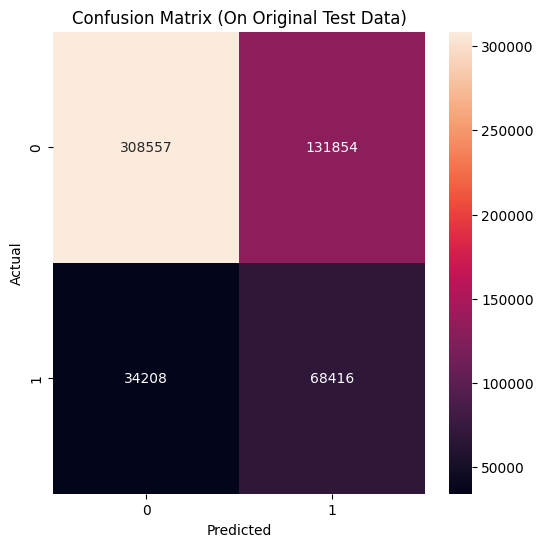

In [19]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns

# Select all columns as features except the target column
features = df.columns.tolist()
features.remove('DEP_DEL15')

target = 'DEP_DEL15'

# Split the dataset into training and testing sets
X = df[features]
y = df[target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Perform undersampling on the training data only
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

cb = CatBoostClassifier(random_state=42, verbose=False, depth= 10, iterations= 300, l2_leaf_reg= 1, learning_rate= 0.15)

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(cb, X_train_scaled, y_train_resampled, cv=cv, scoring='f1')

# Print the mean of the cross validation scores
print(f'Scores for each fold: {scores}')
print(f'Mean f1 score: {scores.mean():.3f}')

# Train CatBoost classifier
cb.fit(X_train_scaled, y_train_resampled)

# Predict on test data
y_pred = cb.predict(X_test_scaled)
y_pred_proba = cb.predict_proba(X_test_scaled)[:, 1]

#Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Display metrics
# Evaluate the model on the original test set
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)

# Confusion matrix
import seaborn as sns
plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, cmap='rocket', fmt='g', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (On Original Test Data)')
plt.show()

Scores for each fold: [0.61920474 0.61881757 0.61878892 0.61909015 0.61713326]
Mean f1 score: 0.619


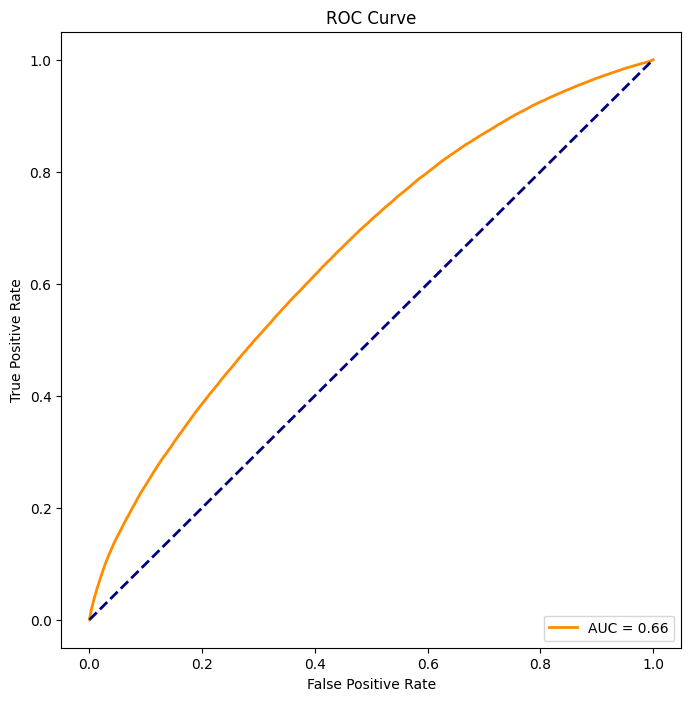

Accuracy: 0.590354212896038
Confusion Matrix:
[[255204 185207]
 [ 37245  65379]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.58      0.70    440411
         1.0       0.26      0.64      0.37    102624

    accuracy                           0.59    543035
   macro avg       0.57      0.61      0.53    543035
weighted avg       0.76      0.59      0.63    543035



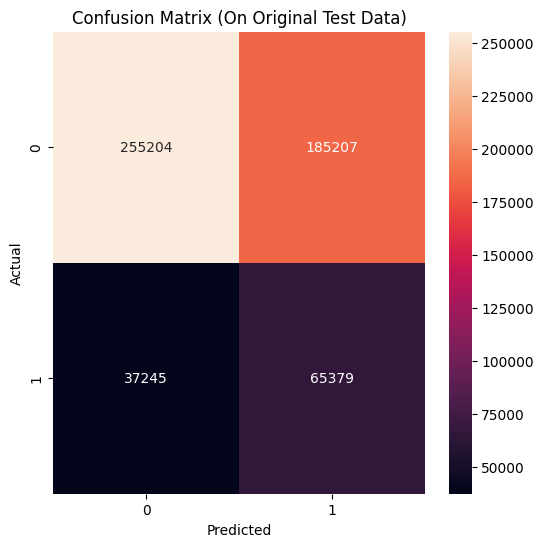

In [4]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns

# Select all columns as features except the target column
features = df.columns.tolist()
features.remove('DEP_DEL15')

# target feature
target = 'DEP_DEL15'

# Split the dataset into training and testing sets
X = df[features]
y = df[target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Perform undersampling on the training data only
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Define Logistic Regression model
model = LogisticRegression(random_state=42)

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train_scaled, y_train_resampled, cv=cv, scoring='f1')

# Print the mean of the cross-validation scores
print(f'Scores for each fold: {scores}')
print(f'Mean f1 score: {scores.mean():.3f}')

# Train Logistic Regression model
model.fit(X_train_scaled, y_train_resampled)

# Predict on test data
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Display metrics
# Evaluate the Logistic Regression model on the original test set
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)

# Confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, cmap='rocket', fmt='g', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (On Original Test Data)')
plt.show()


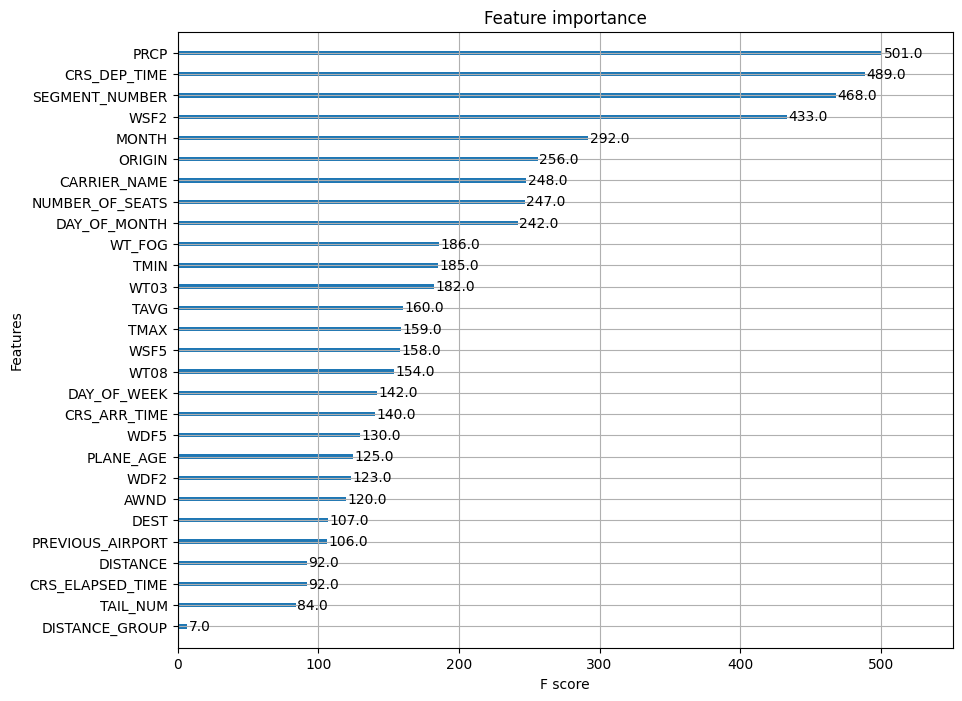

In [ ]:
# plot feature importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(model, ax=ax)
plt.show()

## Evaluation